# Using helper functions to improve the readability of the code

In [29]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import sklearn

def load_and_preprocess_data(datadir='./data/BIfloraexplorer/data/'):
    # 1. Load the data
    data = read_data(datadir)
    
    # Assuming the main dataframe is the second one in the list (index 1)
    df = data[1]
    
    # 2. Define feature columns and target columns
    xcols = ['StaceIV_nativity', 'Atlas_nativity_viaALIENATT_PLANTATT',
             'Stace_Crawley_nativity_aliens', 'SLA', 'LDMC', 'seed_mass',
             'leaf_area', 'mean_veg_height', 'max_veg_height', 'L_PLANTATT',
             'F_PLANTATT', 'R_PLANTATT', 'N_PLANTATT', 'S_PLANTATT', 'L_Doring',
             'F_Doring', 'R_Doring', 'N_Doring', 'S_Doring', 'T_Doring', 'ECPE_CSR',
             'predicted_CSR', 'growth_form', 'succulence', 'life_form', 'biome',
             'origin', 'TDWG_level_1_code', 'GB_Man_hectads_post2000',
             'Ire_hectads_post2000', 'CI_hectads_post2000',
             'GB_Man_hectads_1987_1999', 'Ire_hectads_1987_1999',
             'CI_hectads_1987_1999', 'GB_Man_hectads_2000_2009',
             'Ire_hectads_2000_2009', 'CI_hectads_2000_2009',
             'GB_Man_hectads_2010_2019', 'Ire_hectads_2010_2019',
             'CI_hectads_2010_2019', 'hybrid_propensity', 'scaled_hybrid_propensity']

    ycols = ['GS_1C_pg', 'GS_2C_pg', 'GS_1C_Mbp', 'GS_2C_Mbp']

    X = df[xcols]
    y = df[ycols]

    # 3. Identify numeric and categorical columns
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns

    # 4. Create preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Check scikit-learn version and use appropriate parameter for OneHotEncoder
    sklearn_version = sklearn.__version__
    if sklearn_version >= '0.23':
        onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    else:
        onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', onehot_encoder)
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # 5. Fit and transform the data
    X_processed = preprocessor.fit_transform(X)
    
    # Get feature names
    numeric_feature_names = numeric_features.tolist()
    
    # Check scikit-learn version and use appropriate method
    if sklearn_version >= '0.24':
        categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
    else:
        categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features).tolist()
    
    feature_names = numeric_feature_names + categorical_feature_names

    # Ensure the number of feature names matches the shape of X_processed
    if X_processed.shape[1] != len(feature_names):
        print(f"Warning: Number of features ({X_processed.shape[1]}) doesn't match number of feature names ({len(feature_names)})")
        print("Using generic feature names instead.")
        feature_names = [f'feature_{i}' for i in range(X_processed.shape[1])]

    X_processed = pd.DataFrame(X_processed, columns=feature_names, index=X.index)

    # 6. Handle missing values in target variables
    y_imputer = SimpleImputer(strategy='median')
    y_processed = pd.DataFrame(y_imputer.fit_transform(y), columns=y.columns, index=y.index)

    return X_processed, y_processed, preprocessor

# Helper function to read data (from your original script)
def read_data(datadir):
    data = []
    for file in os.listdir(datadir):
        file_path = os.path.join(datadir, file)
        try:
            df = pd.read_csv(file_path, encoding='latin-1')
            data.append(df)
            print(f"Successfully read {file}")
        except Exception as e:
            print(f"Error reading {file}: {str(e)}")
    return data

In [30]:
import sklearn
# Load and preprocess data
X_processed, y_processed, preprocessor = load_and_preprocess_data()



Successfully read GS_Kew_BI.csv
Successfully read BI_main.csv
Successfully read .~lock.BI_main.csv#
Successfully read chrom_num_BI.csv
Successfully read GS_BI.csv


In [31]:
from sklearn.model_selection import train_test_split
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)


In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np

def select_features(X_train, y_train, sample_size=10000, n_estimators=100, top_k=100):
    all_selected_features = set()
    
    # Use a subset of data if the dataset is large
    if len(X_train) > sample_size:
        indices = np.random.choice(len(X_train), sample_size, replace=False)
        X_sample = X_train.iloc[indices]
        y_sample = y_train.iloc[indices]
    else:
        X_sample = X_train
        y_sample = y_train
    
    for i, target in enumerate(y_train.columns):
        print(f"Selecting features for target: {target}")
        
        # Fast initial feature selection
        selector = SelectKBest(f_regression, k=min(X_sample.shape[1], 1000))
        X_preselected = selector.fit_transform(X_sample, y_sample.iloc[:, i])
        preselected_features = X_sample.columns[selector.get_support()]
        
        # Refine selection using Random Forest
        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
        rf.fit(X_preselected, y_sample.iloc[:, i])
        
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        selected_features = preselected_features[indices[:top_k]]
        all_selected_features.update(selected_features)
        
        print(f"Number of features selected for {target}: {len(selected_features)}")
        print("Top 10 selected features:")
        print(selected_features[:10].tolist())
        print("\n")
    
    print(f"Total number of unique features selected across all targets: {len(all_selected_features)}")
    
    return X_train[list(all_selected_features)], list(all_selected_features)


In [40]:

# Usage
X_train_selected, selected_features = select_features(X_train, y_train)
X_test_selected = X_test[selected_features]

Selecting features for target: GS_1C_pg
Number of features selected for GS_1C_pg: 100
Top 10 selected features:
['life_form_geophyte', 'Stace_Crawley_nativity_aliens_Neo', 'life_form_epiphyte / parasite / phanerophyte', 'seed_mass', 'GB_Man_hectads_1987_1999', 'SLA', 'growth_form_Fern', 'mean_veg_height', 'max_veg_height', 'GB_Man_hectads_2010_2019']


Selecting features for target: GS_2C_pg
Number of features selected for GS_2C_pg: 100
Top 10 selected features:
['life_form_geophyte', 'Stace_Crawley_nativity_aliens_Neo', 'life_form_epiphyte / parasite / phanerophyte', 'seed_mass', 'GB_Man_hectads_1987_1999', 'SLA', 'growth_form_Fern', 'mean_veg_height', 'max_veg_height', 'L_PLANTATT']


Selecting features for target: GS_1C_Mbp
Number of features selected for GS_1C_Mbp: 100
Top 10 selected features:
['life_form_geophyte', 'Stace_Crawley_nativity_aliens_Neo', 'life_form_epiphyte / parasite / phanerophyte', 'seed_mass', 'GB_Man_hectads_1987_1999', 'SLA', 'growth_form_Fern', 'max_veg_heigh

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

def train_and_tune_model(X_train, y_train, n_iter=100, cv=5):
    # Define the parameter space
    param_space = {
        'estimator__n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
        'estimator__max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
        'estimator__min_samples_split': [2, 5, 10],
        'estimator__min_samples_leaf': [1, 2, 4],
        'estimator__bootstrap': [True, False]
    }

    # Initialize the base model
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    # Use MultiOutputRegressor
    multi_rf = MultiOutputRegressor(rf)

    # Initialize RandomizedSearchCV
    rf_random = RandomizedSearchCV(estimator=multi_rf, param_distributions=param_space, 
                                   n_iter=n_iter, cv=cv, verbose=2, random_state=42, 
                                   n_jobs=-1, scoring='neg_mean_squared_error')

    # Fit the random search model
    rf_random.fit(X_train, y_train)

    print("Best parameters found:")
    print(rf_random.best_params_)

    return rf_random.best_estimator_

In [44]:

# Usage
best_model = train_and_tune_model(X_train_selected, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END estimator__bootstrap=True, estimator__max_depth=80, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1800; total time= 4.3min
[CV] END estimator__bootstrap=True, estimator__max_depth=80, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1800; total time= 4.5min
[CV] END estimator__bootstrap=True, estimator__max_depth=80, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=1800; total time= 4.7min
[CV] END estimator__bootstrap=False, estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=800; total time= 3.5min
[CV] END estimator__bootstrap=False, estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=2000; total time= 8.7min
[CV] END estimator__bootstrap=True, estimator__max_depth=80, estima

In [45]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

def evaluate_model(model, X, y):
    # Make predictions
    y_pred = model.predict(X)
    
    # Initialize a dictionary to store metrics
    metrics = {}
    
    # If y is a DataFrame (multi-target), calculate metrics for each target
    if isinstance(y, pd.DataFrame):
        for i, col in enumerate(y.columns):
            metrics[col] = {
                'RMSE': np.sqrt(mean_squared_error(y.iloc[:, i], y_pred[:, i])),
                'MAE': mean_absolute_error(y.iloc[:, i], y_pred[:, i]),
                'R2': r2_score(y.iloc[:, i], y_pred[:, i]),
                'Explained Variance': explained_variance_score(y.iloc[:, i], y_pred[:, i])
            }
    else:  # Single target
        metrics = {
            'RMSE': np.sqrt(mean_squared_error(y, y_pred)),
            'MAE': mean_absolute_error(y, y_pred),
            'R2': r2_score(y, y_pred),
            'Explained Variance': explained_variance_score(y, y_pred)
        }
    
    return metrics



In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def report_results(train_metrics, test_metrics, model, X):
    # Print metrics
    print("Training Metrics:")
    print_metrics(train_metrics)
    print("\nTest Metrics:")
    print_metrics(test_metrics)
    
    # Plot feature importances
    plot_feature_importances(model, X.columns)

def print_metrics(metrics):
    if isinstance(metrics, dict) and isinstance(next(iter(metrics.values())), dict):
        # Multi-target case
        for target, target_metrics in metrics.items():
            print(f"\n  {target}:")
            for metric, value in target_metrics.items():
                print(f"    {metric}: {value:.4f}")
    else:
        # Single-target case
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")

def plot_feature_importances(model, feature_names, top_n=20):
    if hasattr(model, 'estimators_'):
        # MultiOutputRegressor case
        importances = np.mean([est.feature_importances_ for est in model.estimators_], axis=0)
    elif hasattr(model, 'feature_importances_'):
        # Single estimator case
        importances = model.feature_importances_
    else:
        print("Model doesn't have feature_importances_ attribute.")
        return
    
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Get the top n feature importances
    top_indices = indices[:top_n]
    top_importances = importances[top_indices]
    top_features = feature_names[top_indices]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.title(f"Top {top_n} Feature Importances")
    plt.bar(range(top_n), top_importances)
    plt.xticks(range(top_n), top_features, rotation=90)
    plt.tight_layout()
    plt.show()

In [54]:
train_metrics = evaluate_model(best_model, X_train_selected, y_train)
test_metrics = evaluate_model(best_model, X_test_selected, y_test)


Training Metrics:

  GS_1C_pg:
    RMSE: 3.0656
    MAE: 1.2523
    R2: 0.6321
    Explained Variance: 0.6322

  GS_2C_pg:
    RMSE: 6.1314
    MAE: 2.5048
    R2: 0.6321
    Explained Variance: 0.6322

  GS_1C_Mbp:
    RMSE: 3001.2318
    MAE: 1226.5203
    R2: 0.6320
    Explained Variance: 0.6321

  GS_2C_Mbp:
    RMSE: 6003.4183
    MAE: 2453.4586
    R2: 0.6319
    Explained Variance: 0.6320

Test Metrics:

  GS_1C_pg:
    RMSE: 3.4207
    MAE: 1.7544
    R2: 0.4240
    Explained Variance: 0.4244

  GS_2C_pg:
    RMSE: 6.8397
    MAE: 3.5106
    R2: 0.4243
    Explained Variance: 0.4247

  GS_1C_Mbp:
    RMSE: 3349.8259
    MAE: 1719.7561
    R2: 0.4238
    Explained Variance: 0.4242

  GS_2C_Mbp:
    RMSE: 6703.2556
    MAE: 3440.4382
    R2: 0.4232
    Explained Variance: 0.4236


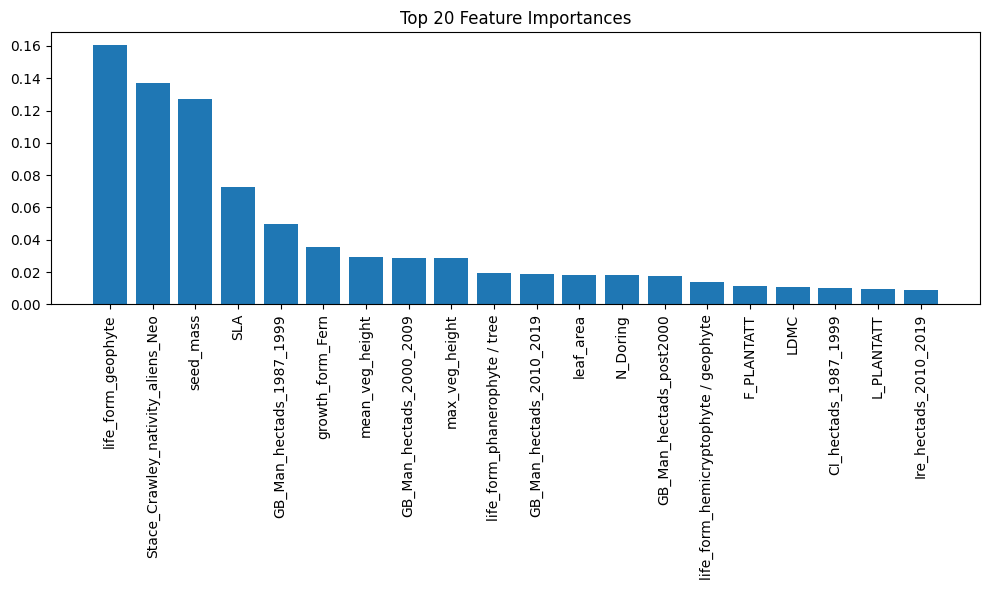

In [55]:
# Usage
report_results(train_metrics, test_metrics, best_model, X_train_selected)

## Summary

Using a combination of ML approaches including feature selection and hyperparameter tuning for use in Random Forest we find nominal predictive power (~60% of variance explained) in predicting the plant genome size. Some features do warrant exploration in phylogenetically informed analyes. 

Namely:
1. life_form
2. nativity
3. seed_mass
4. SLA (specific leaf area)
5. distribution range
6. growth_form
7. mean_veg_height
8. max_veg_height
9. leaf_area. 

PLANTATT values may also be worthwhile: 
Listed Ellenberg categories are L (light), F (moisture, from German ‘Feuchtigkeit’), R (reaction, soil acidity), N (nutrients, fertility), S (salt), T (temperature, only for European data).